In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disaster-tweets/tweets.csv


## Libraries

In [67]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Bidirectional, Dropout, Reshape
from tensorflow.keras.layers import BatchNormalization, TimeDistributed
from tensorflow.keras.layers import LSTM, GRU,GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, sparse_categorical_crossentropy

## Data Loading

In [4]:
tweetds = pd.read_csv('/kaggle/input/disaster-tweets/tweets.csv')
tweetds.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [5]:
tweetds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


In [6]:
tweetds.describe(include='all')

,id,keyword,location,text,target
count,11370.000000,11370,7952,11370,11370.000000
unique,NaN,219,4504,11223,NaN
top,NaN,thunderstorm,United States,I want to help you with my project to save the...,NaN
freq,NaN,93,96,3,NaN
mean,5684.500000,NaN,NaN,NaN,0.185928
std,3282.380615,NaN,NaN,NaN,0.389066
min,0.000000,NaN,NaN,NaN,0.000000
25%,2842.250000,NaN,NaN,NaN,0.000000
50%,5684.500000,NaN,NaN,NaN,0.000000
75%,8526.750000,NaN,NaN,NaN,0.000000


## Data Cleaning

In [7]:
# stopwords
try:
  stop_words = set(stopwords.words("english"))
except:
  nltk.download('stopwords')
  stop_words = set(stopwords.words("english"))

# remove the stopwords and single-character words
def remove_sw_and_sc(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stop_words and len(i) > 1:
            final_text.append(i.strip())
    return " ".join(final_text)

In [8]:
# clean text function
def clean_text(text):
    text = text.lower() # convert to lowercase
    text = re.sub('https?://\S+', '', text) # remove url
    text = re.sub('<.*?>', '', text) # remove html tags
    text = re.sub('&\S+?;', '', text) # remove html entities
    text = re.sub(r'@\S+', '', text) # remove mention
    text = re.sub('[^\w\s]+', '', text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub('\d+', '', text) # remove numbers
    # text = stemmer.stem(text) # stemming
    text = text.strip() # remove whitespace
    return text

# source https://www.kaggle.com/code/masatoshikato/effective-eda-bert-in-nlp-bert-baseline
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' emoji ', string)

In [9]:
X, y = tweetds['text'], tweetds['target']

X = X.apply(clean_text)
X = X.apply(lambda text: remove_emoji(text))
X = X.apply(remove_sw_and_sc)

In [10]:
X.sample(5).values

array(['iran us parrot story missile attack irbil alassad airbases deliberately avoided us casualties',
       'proud thedirtywaronthenhs nhs staff need speak patients dying colleagues bein',
       'new eyewitness stepped forward testify',
       'bloody hell lot binges morning tuesday morning one gooood boy catching',
       'cant bring tweet brexit moment feels raw devastation real risk'],
      dtype=object)

## EDA

In [11]:
tweet_desc = tweetds[['text', 'target']]
tweet_desc.text.sample(10).values

array(['SAVAGE!!!! #FATALITY https://t.co/OWIK6gPzVw',
       'Widow of CIA agent killed in 2009 Afghanistan suicide bomb attack breaks her silence 10 years on https://t.co/GtCOCsBtLx',
       "it already has. it's a desolation.",
       'A train has had a low speed derailment at Hitchin as a result no trains are calling at Hitchin station until furth… https://t.co/5wgzwC4Tde',
       'This is how low has sunk. https://t.co/LqzhBEZsd9',
       'The body of a 10-year old girl who was reported missing from their Kayole home, Nairobi in September last year was… https://t.co/aEsAAoOfhP',
       'Throw some hand sanitizer at them and tell them to use that shit and to touch things minimally. Then o… https://t.co/XEAxPin7ck',
       'God is going to bless you in the same season the devil attacked you.',
       "This is...wrong. I adore Weili but Amanda has been body bagging other women for close to 4 years now. There's only… https://t.co/UtrMmXnga3",
       'Hello all, as you guys know Austra

In [12]:
# Hashtag
tweet_desc['hashtags'] = tweet_desc['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

# Mention
tweet_desc['mention'] = tweet_desc['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))

# Punctuation
def count_punct(text):
    # transform a html entity to count as a symbol
    text = re.sub('&\S+?;', '&', text)
    # count punctuation
    count = sum([1 for char in text if char in string.punctuation])
    return count

tweet_desc['punctuation'] = tweet_desc['text'].apply(lambda x: count_punct(x))
# hashtags and mentions don't count as punctuation
tweet_desc['punctuation'] -= tweet_desc['hashtags'] + tweet_desc['mention']

# Numbers / Digits
tweet_desc['numerics'] = tweet_desc['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

# di bawah ini, symbol, html tags & entities, dan url terhitung juga? kalau gak cleaning dulu

# Number of Words
tweet_desc['word_count'] = tweet_desc['text'].apply(lambda x: len(str(x).split(" ")))

# Number of Character
tweet_desc['char_count'] = tweet_desc['text'].str.len()

tweet_desc.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,text,target,hashtags,mention,punctuation,numerics,word_count,char_count
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1,0,0,4,0,19,125
1,Telangana: Section 144 has been imposed in Bha...,1,0,0,3,2,23,131
2,Arsonist sets cars ablaze at dealership https:...,1,0,0,5,0,7,63
3,Arsonist sets cars ablaze at dealership https:...,1,0,0,10,0,8,87
4,"""Lord Jesus, your love brings freedom and pard...",0,0,0,8,0,23,140


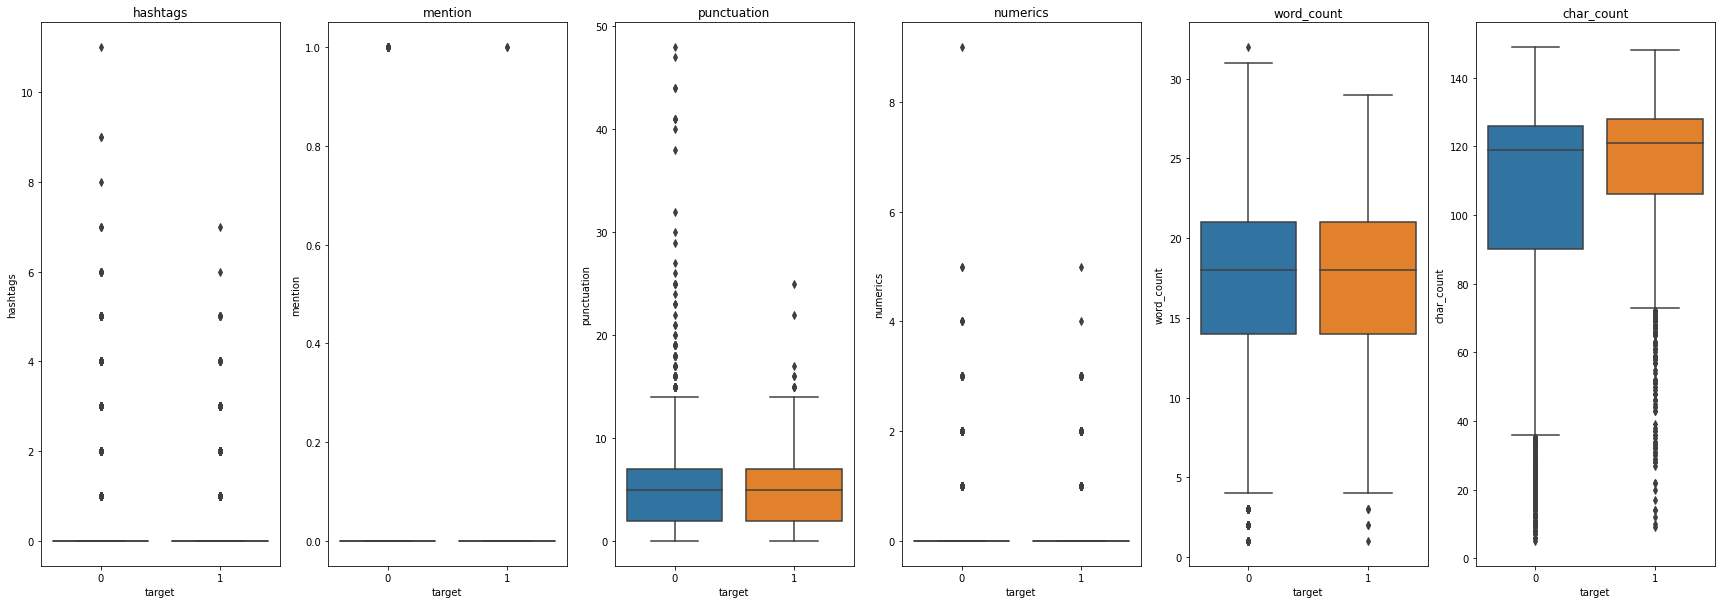

In [13]:
# boxplot
num_columns = tweet_desc.columns[2:]

plt.figure(figsize=(30, 10))
for ind, col in enumerate(num_columns):
    plt.subplot(1, 6, ind+1)
    sns.boxplot(data=tweet_desc, y=col, x='target')
    plt.title(col)
plt.show()

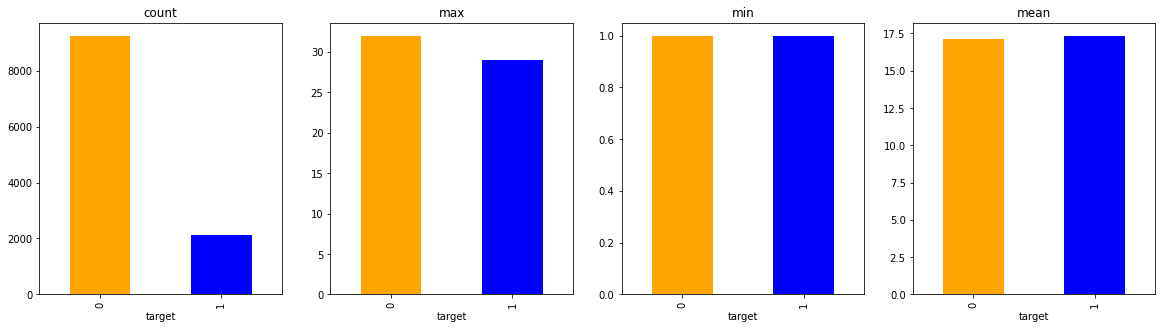

In [14]:
# word count stats
stats = tweet_desc.groupby(['target']).agg(['count', 'max', 'min', 'mean']).word_count.T

plt.figure(figsize=(20,5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    stats.iloc[i].plot.bar(color=['orange', 'blue'])
    plt.title(stats.iloc[i].name)
plt.show()

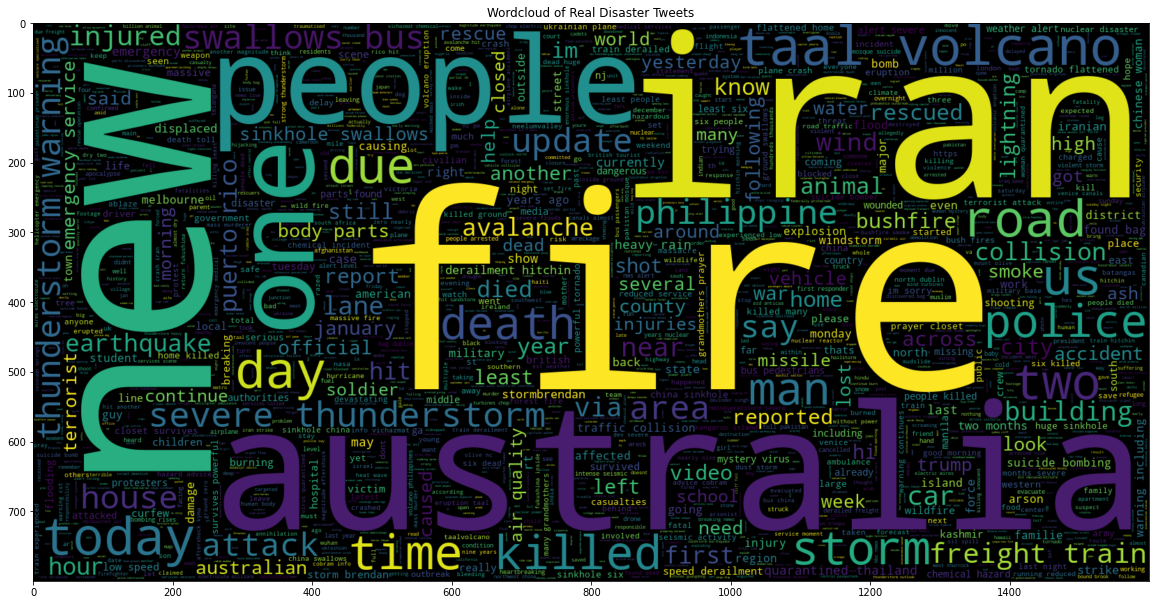

In [15]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(X[y == 1]))
plt.imshow(wc, interpolation = 'bilinear')
plt.title("Wordcloud of Real Disaster Tweets")
plt.show()

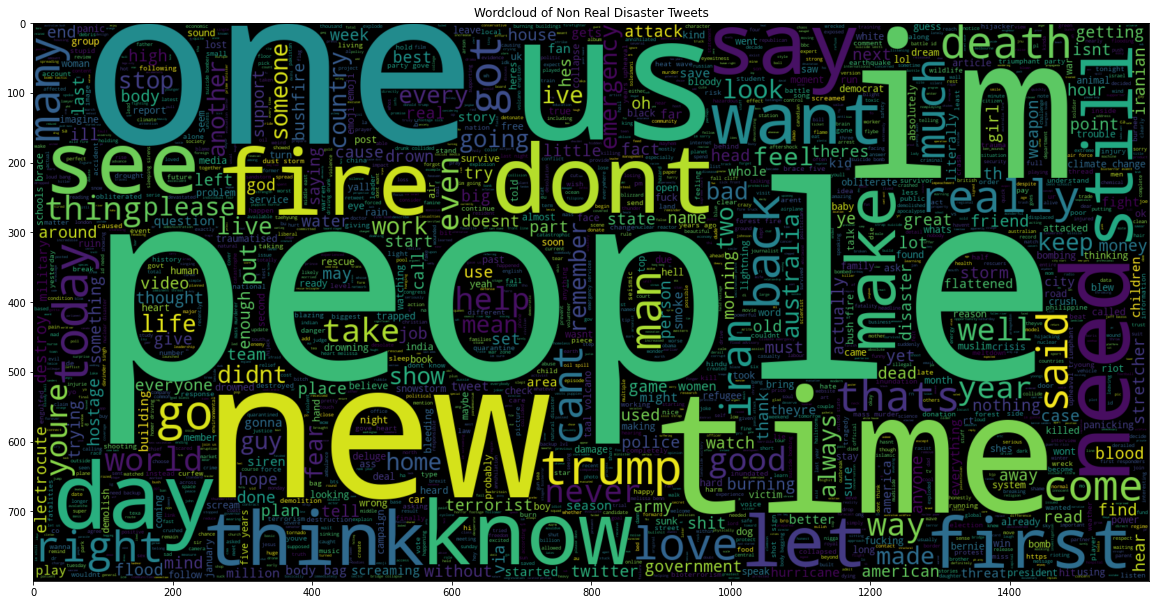

In [16]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(X[y == 0]))
plt.imshow(wc, interpolation = 'bilinear')
plt.title("Wordcloud of Non Real Disaster Tweets")
plt.show()

## Pre-processing Data

### Split Train and Test Data

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=4, shuffle=True)

### Embeddings

In [18]:
# split sentence to word
X_train = X_train.apply(word_tokenize)

In [19]:
EMBEDDING_DIM = 300

w2v = Word2Vec(sentences=X_train, vector_size=EMBEDDING_DIM, window=7, min_count=1, sg=1)
w2v.train(X_train, total_examples=len(X_train), epochs=10)

(746762, 751570)

In [20]:
len(w2v.wv.key_to_index)

17521

In [21]:
def get_weight_matrix(weight_matrix, model, vocab):
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

### Tokenizer

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

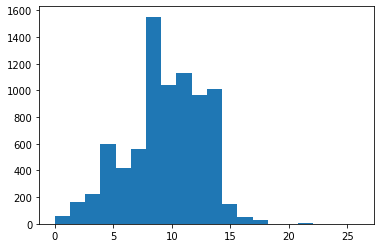

In [23]:
plt.hist([len(x) for x in X_train], bins=20)
plt.show()

In [24]:
maxlen = 20

X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

In [25]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # Add 1 because of reserved 0 index
vocab_size

17522

In [26]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
embedding_matrix = get_weight_matrix(embedding_matrix, w2v.wv.key_to_index, word_index)

## Model

In [27]:
callbacks = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)

### Global Max

In [28]:
#Defining Neural Network
modelGM = Sequential()

modelGM.add(Embedding(vocab_size, 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))

modelGM.add(Dense(256, activation='relu'))
modelGM.add(GlobalMaxPooling1D())
#modelGM.add(Dense(128, activation='relu'))
#modelGM.add(Dense(64, activation='relu'))
modelGM.add(Dense(1, activation='sigmoid'))

modelGM.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['acc'])
modelGM.summary()

2022-07-27 14:42:27.000549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 14:42:27.112350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 14:42:27.113140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 14:42:27.114317: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           5256600   
_________________________________________________________________
dense (Dense)                (None, 20, 256)           77056     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 5,333,913
Trainable params: 77,313
Non-trainable params: 5,256,600
_________________________________________________________________


ead from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 14:42:29.091655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15403 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [29]:
historyGM = modelGM.fit(X_train,
                      y_train,
                      batch_size=64,
                      validation_data=(X_val,y_val),
                      epochs=25,
                      callbacks=callbacks,
                      verbose=1)

2022-07-27 14:42:29.580122: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
125/125 [==============================] - 2s 5ms/step - loss: 1903.4756 - acc: 0.7042 - val_loss: 35.0151 - val_acc: 0.1806
Epoch 2/25
125/125 [==============================] - 1s 4ms/step - loss: 17.8170 - acc: 0.6620 - val_loss: 0.6411 - val_acc: 0.8194
Epoch 3/25
125/125 [==============================] - 1s 4ms/step - loss: 0.5918 - acc: 0.8118 - val_loss: 0.5470 - val_acc: 0.8194
Epoch 4/25
125/125 [==============================] - 0s 3ms/step - loss: 0.5287 - acc: 0.8118 - val_loss: 0.5044 - val_acc: 0.8194
Epoch 5/25
125/125 [==============================] - 0s 3ms/step - loss: 0.5016 - acc: 0.8118 - val_loss: 0.4859 - val_acc: 0.8194
Epoch 6/25
125/125 [==============================] - 0s 3ms/step - loss: 0.4905 - acc: 0.8118 - val_loss: 0.4782 - val_acc: 0.8194
Epoch 7/25
125/125 [==============================] - 0s 4ms/step - loss: 0.4861 - acc: 0.8118 - val_loss: 0.4748 - val_acc: 0.8194
Epoch 8/25
125/125 [==============================] - 0s 3ms/step - los

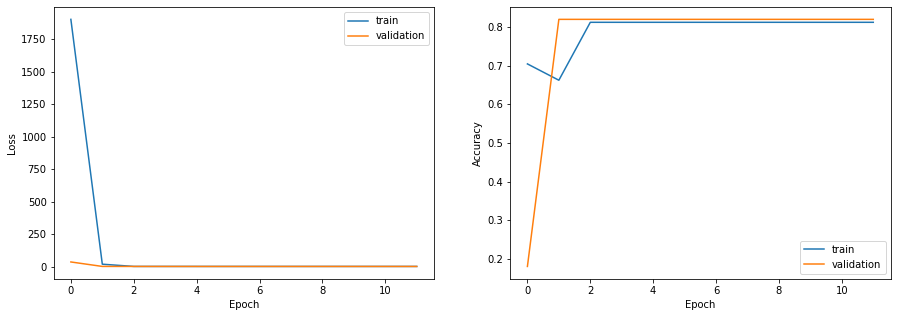

In [30]:
metrics = pd.DataFrame(historyGM.history)

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
ax1.plot(metrics.index, metrics.loss, label = "train")
ax1.plot(metrics.index, metrics.val_loss, label = "validation")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
plt.legend()

ax2 = plt.subplot(122)
ax2.plot(metrics.index, metrics.acc, label = "train")
ax2.plot(metrics.index, metrics.val_acc, label = "validation")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.legend()

plt.show()


### Global Average

In [31]:
#Defining Neural Network
modelGA = Sequential()

modelGA.add(Embedding(vocab_size, 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))

modelGA.add(GlobalAveragePooling1D())
modelGA.add(Dense(128, activation='relu'))
modelGA.add(Dense(64, activation='relu'))
modelGA.add(Dense(1, activation='sigmoid'))

modelGA.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['acc'])
modelGA.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 300)           5256600   
_________________________________________________________________
global_average_pooling1d (Gl (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               38528     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 5,303,449
Trainable params: 46,849
Non-trainable params: 5,256,600
_________________________________________________________________


In [32]:
historyGA = modelGA.fit(X_train,
                      y_train,
                      batch_size=64,
                      validation_data=(X_val,y_val),
                      epochs=25,
                      callbacks=callbacks,
                      verbose=1)

Epoch 1/25
125/125 [==============================] - 1s 5ms/step - loss: 137.4166 - acc: 0.7029 - val_loss: 4.3860 - val_acc: 0.8156
Epoch 2/25
125/125 [==============================] - 0s 4ms/step - loss: 6.7737 - acc: 0.7006 - val_loss: 4.0453 - val_acc: 0.8150
Epoch 3/25
125/125 [==============================] - 0s 3ms/step - loss: 1.7521 - acc: 0.7323 - val_loss: 0.5396 - val_acc: 0.8194
Epoch 4/25
125/125 [==============================] - 0s 3ms/step - loss: 0.5062 - acc: 0.8118 - val_loss: 0.5092 - val_acc: 0.8194
Epoch 5/25
125/125 [==============================] - 1s 5ms/step - loss: 0.4909 - acc: 0.8118 - val_loss: 0.4929 - val_acc: 0.8194
Epoch 6/25
125/125 [==============================] - 0s 3ms/step - loss: 0.4867 - acc: 0.8118 - val_loss: 0.4835 - val_acc: 0.8194
Epoch 7/25
125/125 [==============================] - 0s 3ms/step - loss: 0.4840 - acc: 0.8118 - val_loss: 0.4794 - val_acc: 0.8194
Epoch 8/25
125/125 [==============================] - 0s 3ms/step - loss: 

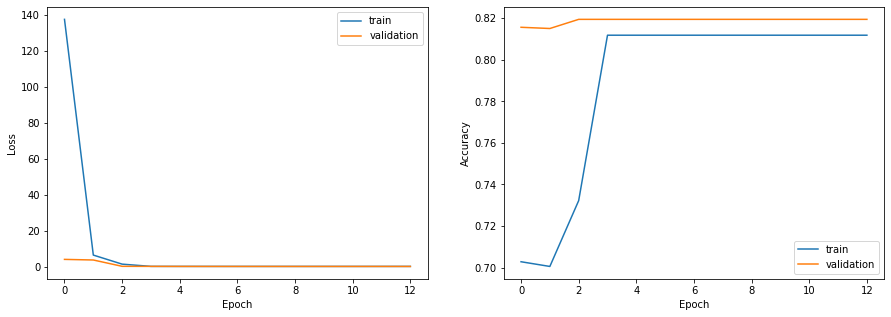

In [33]:
metrics = pd.DataFrame(historyGA.history)

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
ax1.plot(metrics.index, metrics.loss, label = "train")
ax1.plot(metrics.index, metrics.val_loss, label = "validation")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
plt.legend()

ax2 = plt.subplot(122)
ax2.plot(metrics.index, metrics.acc, label = "train")
ax2.plot(metrics.index, metrics.val_acc, label = "validation")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.legend()

plt.show()

### LSTM

In [34]:
#Defining Neural Network
modelLSTM = Sequential()

modelLSTM.add(Embedding(vocab_size, 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))

modelLSTM.add(LSTM(units=200, recurrent_dropout=0.2, dropout=0.2, return_sequences=False))
modelLSTM.add(Dense(1, activation='sigmoid'))

modelLSTM.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['acc'])
modelLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 300)           5256600   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               400800    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 5,657,601
Trainable params: 401,001
Non-trainable params: 5,256,600
_________________________________________________________________


In [35]:
historyLSTM = modelLSTM.fit(X_train,
                      y_train,
                      batch_size=64,
                      validation_data=(X_val,y_val),
                      epochs=25,
                      callbacks=callbacks,
                      verbose=1)

Epoch 1/25
125/125 [==============================] - 14s 97ms/step - loss: 0.4868 - acc: 0.8109 - val_loss: 0.4759 - val_acc: 0.8194
Epoch 2/25
125/125 [==============================] - 11s 91ms/step - loss: 0.4794 - acc: 0.8118 - val_loss: 0.4592 - val_acc: 0.8194
Epoch 3/25
125/125 [==============================] - 11s 87ms/step - loss: 0.4753 - acc: 0.8118 - val_loss: 0.4619 - val_acc: 0.8194
Epoch 4/25
125/125 [==============================] - 12s 95ms/step - loss: 0.4777 - acc: 0.8118 - val_loss: 0.4599 - val_acc: 0.8194
Epoch 5/25
125/125 [==============================] - 12s 94ms/step - loss: 0.4795 - acc: 0.8118 - val_loss: 0.4619 - val_acc: 0.8194
Epoch 6/25
125/125 [==============================] - 11s 87ms/step - loss: 0.4832 - acc: 0.8113 - val_loss: 0.4654 - val_acc: 0.8194
Epoch 7/25
125/125 [==============================] - 11s 87ms/step - loss: 0.4776 - acc: 0.8118 - val_loss: 0.4680 - val_acc: 0.8194
Epoch 8/25
125/125 [==============================] - 11s 88ms

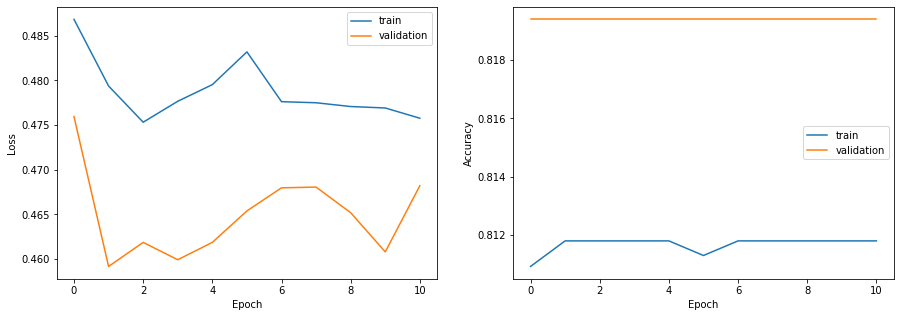

In [36]:
metrics = pd.DataFrame(historyLSTM.history)

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
ax1.plot(metrics.index, metrics.loss, label = "train")
ax1.plot(metrics.index, metrics.val_loss, label = "validation")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
plt.legend()

ax2 = plt.subplot(122)
ax2.plot(metrics.index, metrics.acc, label = "train")
ax2.plot(metrics.index, metrics.val_acc, label = "validation")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.legend()

plt.show()

### GRU

In [41]:
#Defining Neural Network
modelGRU = Sequential()

modelGRU.add(Embedding(vocab_size, 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))

modelGRU.add(GRU(units=200, recurrent_dropout=0.2, dropout=0.2, return_sequences=False))
modelGRU.add(Dense(1, activation='sigmoid'))

modelGRU.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['acc'])
modelGRU.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 300)           5256600   
_________________________________________________________________
gru (GRU)                    (None, 200)               301200    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 5,558,001
Trainable params: 301,401
Non-trainable params: 5,256,600
_________________________________________________________________


In [42]:
historyGRU = modelGRU.fit(X_train,
                      y_train,
                      batch_size=64,
                      validation_data=(X_val,y_val),
                      epochs=25,
                      callbacks=callbacks,
                      verbose=1)

Epoch 1/25
125/125 [==============================] - 13s 89ms/step - loss: 0.5047 - acc: 0.8047 - val_loss: 0.4693 - val_acc: 0.8168
Epoch 2/25
125/125 [==============================] - 11s 87ms/step - loss: 0.4865 - acc: 0.8113 - val_loss: 0.4702 - val_acc: 0.8168
Epoch 3/25
125/125 [==============================] - 10s 79ms/step - loss: 0.4851 - acc: 0.8118 - val_loss: 0.4683 - val_acc: 0.8194
Epoch 4/25
125/125 [==============================] - 10s 78ms/step - loss: 0.4850 - acc: 0.8115 - val_loss: 0.4693 - val_acc: 0.8194
Epoch 5/25
125/125 [==============================] - 10s 83ms/step - loss: 0.4806 - acc: 0.8118 - val_loss: 0.4684 - val_acc: 0.8194
Epoch 6/25
125/125 [==============================] - 10s 77ms/step - loss: 0.4896 - acc: 0.8118 - val_loss: 0.4923 - val_acc: 0.8194
Epoch 7/25
125/125 [==============================] - 10s 80ms/step - loss: 0.4802 - acc: 0.8118 - val_loss: 0.4729 - val_acc: 0.8194
Epoch 8/25
125/125 [==============================] - 10s 80ms

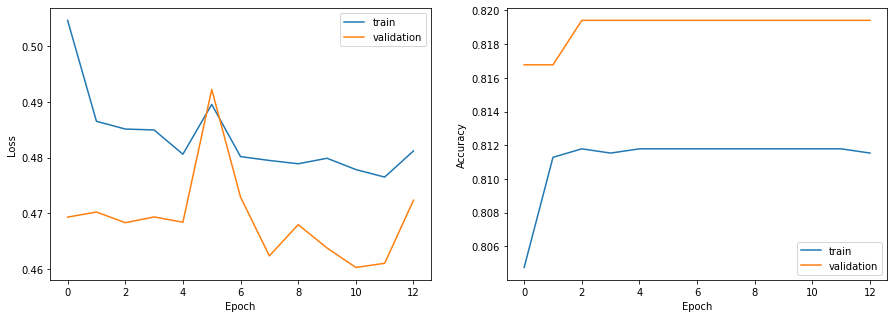

In [43]:
metrics = pd.DataFrame(historyGRU.history)

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
ax1.plot(metrics.index, metrics.loss, label = "train")
ax1.plot(metrics.index, metrics.val_loss, label = "validation")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
plt.legend()

ax2 = plt.subplot(122)
ax2.plot(metrics.index, metrics.acc, label = "train")
ax2.plot(metrics.index, metrics.val_acc, label = "validation")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.legend()

plt.show()

### Bidirectional LSTM 

In [47]:
def make_model(iter = 1, hidden=100):
    input = Input(shape=[20])

    x = Reshape((20, 1))(input)
    
    for _ in range(iter):
        x = Bidirectional(LSTM(hidden, return_sequences=True))(x)
        
    x = Bidirectional(LSTM(hidden))(x)
    x = Dense((hidden+40)/2, activation="relu")(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=input, outputs=output)
    model.compile(loss="binary_crossentropy", metrics="accuracy", optimizer="adam")
    return model

In [48]:
modelBLSTM = make_model(1, 100)
modelBLSTM.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 20, 1)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 200)           81600     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_8 (Dense)              (None, 70)                14070     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 71        
Total params: 336,541
Trainable params: 336,541
Non-trainable params: 0
_______________________________________________________

In [49]:
historyBLSTM = modelBLSTM.fit(X_train,
                      y_train,
                      batch_size=64,
                      validation_data=(X_val,y_val),
                      epochs=25,
                      callbacks=callbacks,
                      verbose=1)

Epoch 1/25


2022-07-27 14:50:43.600893: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


125/125 [==============================] - 15s 19ms/step - loss: 0.4808 - accuracy: 0.8117 - val_loss: 0.4531 - val_accuracy: 0.8194
Epoch 2/25
125/125 [==============================] - 2s 12ms/step - loss: 0.4721 - accuracy: 0.8117 - val_loss: 0.4582 - val_accuracy: 0.8194
Epoch 3/25
125/125 [==============================] - 1s 10ms/step - loss: 0.4651 - accuracy: 0.8118 - val_loss: 0.4555 - val_accuracy: 0.8194
Epoch 4/25
125/125 [==============================] - 1s 10ms/step - loss: 0.4658 - accuracy: 0.8118 - val_loss: 0.4541 - val_accuracy: 0.8194
Epoch 5/25
125/125 [==============================] - 1s 10ms/step - loss: 0.4619 - accuracy: 0.8117 - val_loss: 0.4595 - val_accuracy: 0.8194
Epoch 6/25
125/125 [==============================] - 1s 10ms/step - loss: 0.4617 - accuracy: 0.8117 - val_loss: 0.4553 - val_accuracy: 0.8194
Epoch 7/25
125/125 [==============================] - 1s 11ms/step - loss: 0.4606 - accuracy: 0.8117 - val_loss: 0.4565 - val_accuracy: 0.8194
Epoch 8/2

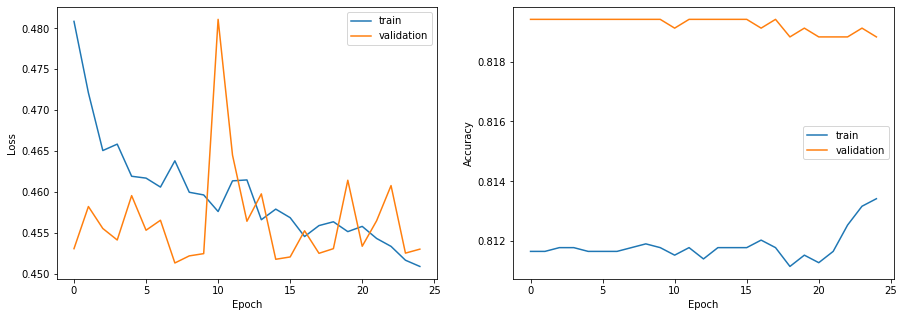

In [51]:
metrics = pd.DataFrame(historyBLSTM.history)

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
ax1.plot(metrics.index, metrics.loss, label = "train")
ax1.plot(metrics.index, metrics.val_loss, label = "validation")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
plt.legend()

ax2 = plt.subplot(122)
ax2.plot(metrics.index, metrics.accuracy, label = "train")
ax2.plot(metrics.index, metrics.val_accuracy, label = "validation")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.legend()

plt.show()

### Bidirectional GRU

In [55]:
modelBGRU = Sequential()
modelBGRU.add(Embedding(vocab_size, 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))
modelBGRU.add(Bidirectional(GRU(128, return_sequences=True)))
modelBGRU.add(GlobalMaxPooling1D())
modelBGRU.add(Dense(128, activation="relu"))
modelBGRU.add(BatchNormalization())
modelBGRU.add(Dense(64, activation="relu"))
modelBGRU.add(Dense(1, activation="sigmoid"))

modelBGRU.compile(loss=BinaryCrossentropy(from_logits=False),
                optimizer=Adam(learning_rate = 0.000003),
                metrics=["acc"])
modelBGRU.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 20, 300)           5256600   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 20, 256)           330240    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                

In [56]:
historyBGRU = modelBGRU.fit(X_train,
                      y_train,
                      batch_size=64,
                      validation_data=(X_val,y_val),
                      epochs=25,
                      callbacks=callbacks,
                      verbose=1)

Epoch 1/25
125/125 [==============================] - 5s 13ms/step - loss: 0.5389 - acc: 0.8045 - val_loss: 0.6516 - val_acc: 0.8168
Epoch 2/25
125/125 [==============================] - 1s 10ms/step - loss: 0.5032 - acc: 0.8118 - val_loss: 0.6343 - val_acc: 0.8133
Epoch 3/25
125/125 [==============================] - 1s 9ms/step - loss: 0.4909 - acc: 0.8118 - val_loss: 0.5779 - val_acc: 0.8194
Epoch 4/25
125/125 [==============================] - 1s 7ms/step - loss: 0.4827 - acc: 0.8118 - val_loss: 0.5091 - val_acc: 0.8194
Epoch 5/25
125/125 [==============================] - 1s 8ms/step - loss: 0.4850 - acc: 0.8118 - val_loss: 0.5230 - val_acc: 0.8194
Epoch 6/25
125/125 [==============================] - 1s 11ms/step - loss: 0.4797 - acc: 0.8118 - val_loss: 0.5344 - val_acc: 0.8188
Epoch 7/25
125/125 [==============================] - 1s 7ms/step - loss: 0.4806 - acc: 0.8118 - val_loss: 0.4715 - val_acc: 0.8194
Epoch 8/25
125/125 [==============================] - 1s 8ms/step - loss:

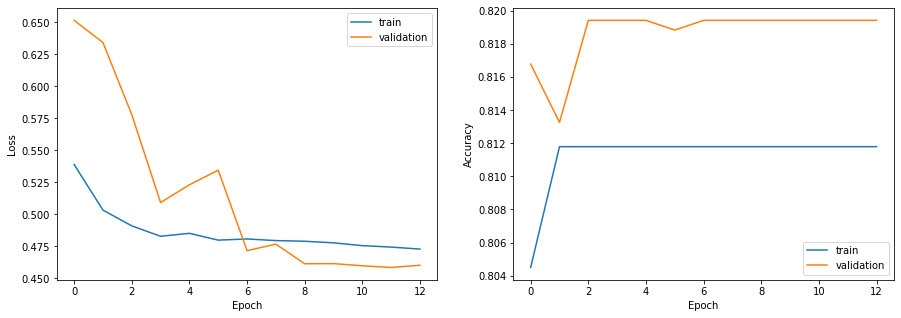

In [58]:
metrics = pd.DataFrame(historyBGRU.history)

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
ax1.plot(metrics.index, metrics.loss, label = "train")
ax1.plot(metrics.index, metrics.val_loss, label = "validation")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
plt.legend()

ax2 = plt.subplot(122)
ax2.plot(metrics.index, metrics.acc, label = "train")
ax2.plot(metrics.index, metrics.val_acc, label = "validation")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.legend()

plt.show()

### Combination

In [72]:
def model(input_shape,size,emb_size):
    lr=1e-3
    md= Sequential()
    md.add(Embedding(size, emb_size, input_length=input_shape))
    md.add(BatchNormalization())
    md.add(Bidirectional(GRU(50,return_sequences=True),\
                         input_shape = (emb_size,1)))
    
    md.add(BatchNormalization())
    md.add(Dropout(0.3))
    md.add(TimeDistributed(Dense(50,activation="softmax")))
    md.add(BatchNormalization())
    md.add(Dropout(0.1))
    md.add(Dense(1,activation="sigmoid"))
    md.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(lr),metrics=["acc"])
    return md

In [73]:
modelComb = model(maxlen, vocab_size, EMBEDDING_DIM)
modelComb.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 20, 300)           5256600   
_________________________________________________________________
batch_normalization_9 (Batch (None, 20, 300)           1200      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 20, 100)           105600    
_________________________________________________________________
batch_normalization_10 (Batc (None, 20, 100)           400       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 100)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 50)            5050      
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 50)          

In [74]:
historyComb = modelComb.fit(X_train,
                      y_train,
                      batch_size=64,
                      validation_data=(X_val,y_val),
                      epochs=25,
                      callbacks=callbacks,
                      verbose=1)

Epoch 1/25
125/125 [==============================] - 5s 15ms/step - loss: 1.7191 - acc: 0.6555 - val_loss: 2.7388 - val_acc: 0.8194
Epoch 2/25
125/125 [==============================] - 1s 12ms/step - loss: 0.8271 - acc: 0.7467 - val_loss: 1.6759 - val_acc: 0.8194
Epoch 3/25
125/125 [==============================] - 1s 11ms/step - loss: 0.6923 - acc: 0.7570 - val_loss: 0.7213 - val_acc: 0.8131
Epoch 4/25
125/125 [==============================] - 1s 11ms/step - loss: 0.4192 - acc: 0.7811 - val_loss: 0.5792 - val_acc: 0.7886
Epoch 5/25
125/125 [==============================] - 2s 12ms/step - loss: 0.2656 - acc: 0.7858 - val_loss: 0.3828 - val_acc: 0.7877
Epoch 6/25
125/125 [==============================] - 1s 11ms/step - loss: 0.2235 - acc: 0.7868 - val_loss: 0.4403 - val_acc: 0.7896
Epoch 7/25
125/125 [==============================] - 1s 11ms/step - loss: 0.1936 - acc: 0.7875 - val_loss: 0.4519 - val_acc: 0.7893
Epoch 8/25
125/125 [==============================] - 1s 11ms/step - 

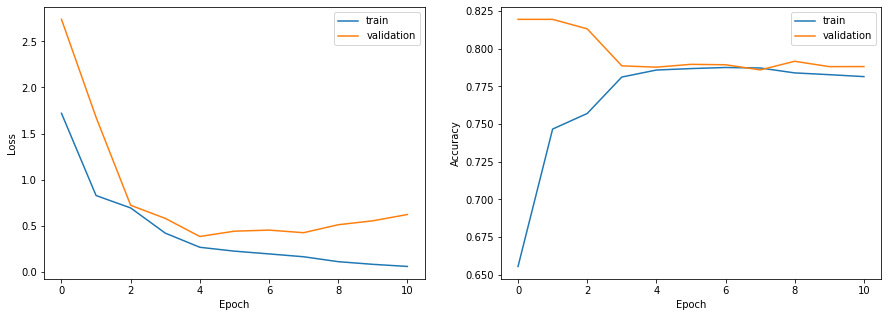

In [75]:
metrics = pd.DataFrame(historyComb.history)

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
ax1.plot(metrics.index, metrics.loss, label = "train")
ax1.plot(metrics.index, metrics.val_loss, label = "validation")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
plt.legend()

ax2 = plt.subplot(122)
ax2.plot(metrics.index, metrics.acc, label = "train")
ax2.plot(metrics.index, metrics.val_acc, label = "validation")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.legend()

plt.show()